In [15]:
import torch
import torchvision.models as models
import torch.nn as nn
import cv2
import numpy as np
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet50
import torch.nn as nn
import pandas as pd
import re

### step 1. 사전 취향 탐색 : 장르 제시하고 한가지 입력 받기

In [16]:
music_genres = ['OST', '뉴에이지', '댄스/팝', '락', '락/메탈', '랩/힙합', '메탈', '발라드', '알앤비/소울', '월드뮤직', '인디', '일렉트로닉', '팝', '포크/어쿠스틱']

print("좋아하는 음악 장르 취향을 골라주세요!")
for i, genre in enumerate(music_genres, 1):
    print(f"{i}. {genre}")

# 사용자로부터 입력 받기
selected_genre_index = int(input("선택지 번호를 입력하세요: ")) - 1

# 선택한 장르 출력
selected_genre = music_genres[selected_genre_index]
print(f"선택한 음악 장르: {selected_genre}")


좋아하는 음악 장르 취향을 골라주세요!
1. OST
2. 뉴에이지
3. 댄스/팝
4. 락
5. 락/메탈
6. 랩/힙합
7. 메탈
8. 발라드
9. 알앤비/소울
10. 월드뮤직
11. 인디
12. 일렉트로닉
13. 팝
14. 포크/어쿠스틱
선택한 음악 장르: 발라드


### step 2. 릴스 썸네일 이미지 입력 받기

In [17]:
img_path = input('릴스의 썸네일로 사용하실 사진을 보여주세요!') #경로로 입력 받기

### step 3. 배경 분류

In [18]:
folders = ['공연장', '공원', '공항', '기차', '도시_낮',
           '도시_밤', '바다_낮', '바다_밤', '설원', '스포츠경기장',
           '시골', '음식점', '카페', '칵테일바', '포차', '노을',
           '밝은하늘', '밤하늘', '헬스장']


# Define the path to your saved model file
model_path = '/Users/chaewon/Downloads/resnet50_best_adamW.pth'

# Create an instance of the ResNet50 model
model = models.resnet50(pretrained=False)

# Modify the classifier layer based on your requirements
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(folders))

# Load the pre-trained weights from the saved file, map to CPU
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# Update the classifier layer weights and biases with the loaded state dictionary
model.load_state_dict(checkpoint)

device = torch.device("mps")
background_model = model.to(device)



/Users/chaewon/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/chaewon/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
import torch
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = img_path #위에서 input받은 경로
input_image = Image.open(image_path).convert("RGB")
input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.to(device)

# Set the model to evaluation mode
background_model.eval()

# Perform inference
with torch.no_grad():
    output = background_model(input_tensor)

predicted_class_index = torch.argmax(output).item()
background = folders[predicted_class_index]


print("Predicted background Label:", background)

Predicted background Label: 공원


### step 4. 얼굴 detect 및 표정 감정분류

In [20]:
nb_classes = 4
class CustomResNet50(nn.Module):
    def __init__(self):
        super(CustomResNet50, self).__init__()
        self.resnet50 = resnet50(pretrained=False)
        in_features = self.resnet50.fc.in_features
        self.fc = nn.Linear(in_features, nb_classes)

    def forward(self, x):
        x = self.resnet50(x)
        x = self.fc(x)
        return x


In [21]:
# Load the entire model
face_model = torch.load('/Users/chaewon/Desktop/컨퍼런스/emotion_classification.pth')
face_model = face_model.to(device)
# Set the model to evaluation mode
face_model.eval()

CustomResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [22]:
import dlib
import cv2
from matplotlib import pyplot as plt

emotion_classifier = face_model
EMOTIONS = ["Happy", "Neutral", "Sad", "Surprising"]

def predict_emotion(image_path):
    # Load an image
    frame = cv2.imread(image_path)

    # Convert color to gray scale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Convert grayscale to RGB
    rgb_frame = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # Face detection using Dlib
    detector = dlib.get_frontal_face_detector()
    faces = detector(gray)

    if len(faces) > 0:
        # Assume the first face is the subject
        face = faces[0]

        # Extract face coordinates
        fX, fY, fW, fH = face.left(), face.top(), face.width(), face.height()

        # Crop and resize the face region
        face_roi = rgb_frame[fY:fY + fH, fX:fX + fW]
        face_roi = cv2.resize(face_roi, (224, 224))

        # Convert to PyTorch tensor with correct shape and channels
        face_tensor = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])(face_roi).unsqueeze(0).to(device)

        # Emotion prediction using PyTorch model
        face_model.eval()
        with torch.no_grad():
            outputs = face_model(face_tensor)
            _, preds = torch.max(outputs, 1)
            label = EMOTIONS[preds.item()]

        # Draw a rectangle around the face and put the label
        cv2.rectangle(frame, (fX, fY), (fX + fW, fY + fH), (0, 255, 0), 2)
        cv2.putText(frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

        # Convert BGR image to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the image using Matplotlib
        plt.imshow(frame_rgb)
        plt.title(f"Predicted Emotion: {label}")
        plt.axis("off")  # Turn off axis numbers
        plt.show()
        return label
    else:
        print("No face detected in the image.")


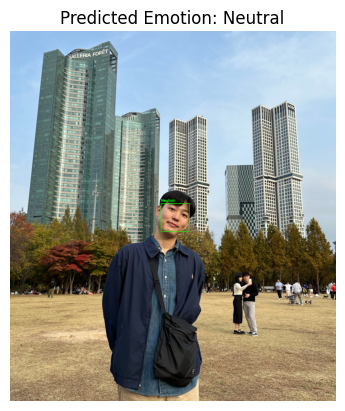

In [23]:
face_emotion = predict_emotion(img_path)

In [24]:
print('감지된 배경 :', background)
print('감지된 표정 :', face_emotion)

감지된 배경 : 공원
감지된 표정 : Neutral


### step 5. 감지된 배경과 표정으로 후보 플리 제작

In [25]:
playlist = pd.read_csv('/Users/chaewon/Desktop/컨퍼런스/final_playlist.csv')
playlist = playlist[playlist['배경'] == background] #배경으로 한 번 거르고

#face_emotion으로 다시 거르기
if face_emotion == 'Happy':
    playlist = playlist[((playlist['가사 감정'] == 'love') & (playlist['템포'] == '빠름')) |
                                (playlist['가사 감정'] == 'excited')]
elif face_emotion == 'Surprising':
    playlist = playlist[playlist['가사 감정'] == 'excited']
elif face_emotion == 'Sad':
    playlist = playlist[playlist['가사 감정'] == 'missing']
elif face_emotion == 'Neutral':
    playlist = playlist[(playlist['가사 감정'] == 'love') & (playlist['템포'] != '빠름')]

playlist #후보 플리


,가수,노래 제목,벅스 링크,음악번호,가사,앨범사진,템포,배경,accumulated,love_ratio,excited_ratio,missing_ratio,앨범명,벅스 앨범 링크,장르,가사 감정
51,Finn Askew,Roses,https://music.bugs.co.kr/track/70444855?wl_ref...,70444855.0,Hey rose I bought you five roses\nWon't you co...,https://image.bugsm.co.kr/album/images/200/143...,보통,공원,"{'love': 14.387019029818475, 'excited': 2.1587...",0.234247,0.035149,0.004379,Roses,https://music.bugs.co.kr/album/14383901?wl_ref...,랩/힙합,love
52,Josie Dunne,Old School,https://music.bugs.co.kr/track/5109943,5109943.0,Shows up right when he said would\nWith flower...,https://image.bugsm.co.kr/album/images/200/708...,보통,공원,"{'love': 14.804976030252874, 'excited': 0.4200...",0.300321,0.008520,0.014151,To Be The Little Fish,https://music.bugs.co.kr/album/708593?wl_ref=S...,팝,love
693,태일,Starlight (스물다섯 스물하나 OST),https://music.bugs.co.kr/track/6146768?wl_ref=...,6146768.0,난 지금 널 향해 달려가고 있어\n숨이 턱까지 차올라 괜찮아\n잠시 후 널 마주할 ...,https://image.bugsm.co.kr/album/images/200/407...,보통,공원,"{'love': 11.826996413990855, 'excited': 0.1764...",0.273872,0.004086,0.108853,스물다섯 스물하나 OST Part 1,https://music.bugs.co.kr/album/4071134?wl_ref=...,"댄스/팝,OST",love
694,블랙핑크,Ice Cream,https://music.bugs.co.kr/track/32005270,32005270.0,Come a little closer\nCause you looking thirst...,https://image.bugsm.co.kr/album/images/200/203...,보통,공원,"{'love': 17.124336224980652, 'excited': 0.8496...",0.188948,0.009375,0.008923,Ice Cream (with Selena Gomez),https://music.bugs.co.kr/album/20346167?wl_ref...,댄스/팝,love
696,크러쉬,자나깨나 (Feat. 조이),https://music.bugs.co.kr/track/31918097,31918097.0,자나깨나\n생각에 잠겨 맨날\n생각해 자나깨나\n괜찮아 꽤나\n따분해 짱 박힌 돌 ...,https://image.bugsm.co.kr/album/images/200/203...,보통,공원,"{'love': 16.66342653008178, 'excited': 2.13141...",0.249725,0.031942,0.056555,homemade 1,https://music.bugs.co.kr/album/20326024?wl_ref...,알앤비/소울,love
698,박재범,All I Wanna Do,https://music.bugs.co.kr/track/30425547?wl_ref...,30425547.0,Girl 말해줘 네 마음 바로 지금\nBaby 같이 올라가자 하늘 위로\nAll I...,https://image.bugsm.co.kr/album/images/200/200...,보통,공원,"{'love': 8.388195339590311, 'excited': 2.88050...",0.136904,0.047013,0.038553,EVERYTHING YOU WANTED,https://music.bugs.co.kr/album/20062066?wl_ref...,알앤비/소울,love
699,여자친구,귀를 기울이면 (LOVE WHISPER),https://music.bugs.co.kr/track/30737162,30737162.0,내 맘을 말로 표현할 수 없어 \n스치듯 기분 좋은 바람들과\n너와 나 함께 들었던...,https://image.bugsm.co.kr/album/images/200/201...,보통,공원,"{'love': 15.280547501519322, 'excited': 3.1660...",0.449435,0.093120,0.046673,여자친구 The 5th Mini Album <PARALLEL>,https://music.bugs.co.kr/album/20111263?wl_ref...,댄스/팝,love
703,엔시티드림,주인공 (Irreplaceable),https://music.bugs.co.kr/track/6109181?wl_ref=...,6109181.0,Irreplaceable irreplaceable\n아주 오랜 얘기처럼\n당연한 것...,https://image.bugsm.co.kr/album/images/200/404...,보통,공원,"{'love': 17.7541603888385, 'excited': 4.031070...",0.229457,0.052098,0.130520,맛 (Hot Sauce) - The 1st Album,https://music.bugs.co.kr/album/4043860?wl_ref=...,랩/힙합,love
705,이달의소녀,Why Not?,https://music.bugs.co.kr/track/5999453?wl_ref=...,5999453.0,I'm a bad girl 다 말하지\n대답을 빼앗고 내 입을 닫지\n그 아래 깨물...,https://image.bugsm.co.kr/album/images/200/998...,보통,공원,"{'love': 9.344836230389774, 'excited': 4.22000...",0.094341,0.042603,0.060067,[12:00],https://music.bugs.co.kr/album/998062?wl_ref=S...,댄스/팝,love
707,시도,가보자 (스물다섯 스물하나 OST),https://music.bugs.co.kr/track/6151997,6151997.0,모두가 잠든 이 거리\n보랏빛 하늘 그 속에\n떠다니는 구름 같아 난\n가끔은 비를...,https://image.bugsm.co.kr/album/images/200/407...,보통,공원,"{'love': 7.951185974292457, 'excited': 3.27900...",0.188958,0.077925,0.001604,스물다섯 스물하나 OST Part 8,https://music.bugs.co.kr/album/4072720?wl_ref=...,"댄스/팝,OST",love


### step 6. 개인화를 통한 최종 노래 추천

사전 질문 장르와 일치하는 음악 2곡, 나머지 랜덤으로 1곡 추천

일치하는 장르가 1곡밖에 없다면 그 곡 추천, 나머지 랜덤으로 2곡 추천

일치하는 장르가 아예 없다면 후보 플레이리스트에서 랜덤 3곡 추천

In [26]:
import pandas as pd

# Assume 'playlist' is your DataFrame and 'selected_genre' is the selected genre
# No need to split 'selected_genre' since it's a single genre

# Check if the selected genre is present in any row of the 'playlist'
selected_rows = playlist[playlist['장르'].apply(lambda x: selected_genre in x.split(','))]

if not selected_rows.empty:
    # If there is more than one row with the selected genre, select 2 random rows with that genre
    selected_rows = selected_rows.sample(n=min(2, len(selected_rows)))

    # Select 1 random row from other genres, if available
    other_rows = playlist[~playlist['장르'].apply(lambda x: selected_genre in x.split(','))]
    if not other_rows.empty:
        other_rows = other_rows.sample(n=1)
    else:
        # If no other rows are available, handle this case accordingly (e.g., select a default row)
        other_rows = pd.DataFrame(columns=playlist.columns)  # Empty DataFrame

    # Concatenate the selected rows
    final_selection = pd.concat([selected_rows, other_rows])
else:
    # If the selected genre is not present or the playlist has 3 or fewer rows, recommend the entire playlist
    if len(playlist) <= 3:
        final_selection = playlist.copy()
    else:
        # If the playlist has more than 3 rows, select 3 random rows
        final_selection = playlist.sample(n=3, replace=True)  # Use replace=True for sampling with replacement

# Display the final selection
final_selection


,가수,노래 제목,벅스 링크,음악번호,가사,앨범사진,템포,배경,accumulated,love_ratio,excited_ratio,missing_ratio,앨범명,벅스 앨범 링크,장르,가사 감정
715,적재,나랑 같이 걸을래,https://music.bugs.co.kr/track/6004647,6004647.0,가을밤이 찾아와\n그대를 비추고\n또 나를 감싸네\n눈을 감을 때마다\n향기로운 네...,https://image.bugsm.co.kr/album/images/200/998...,느림,공원,"{'love': 9.440244460478425, 'excited': 5.96934...",0.212444,0.134335,0.043119,나랑 같이 걸을래 (바른연애 길잡이 X 적재),https://music.bugs.co.kr/album/998892?wl_ref=S...,"인디,발라드",love
710,적재,"손을 잡는다거나, 같이 걷는다거나",https://music.bugs.co.kr/track/6148544,6148544.0,하고 싶은 말을 하나씩\n써 내려가다가\n문득 보고 싶은 맘이\n창밖에 막 차오를 ...,https://image.bugsm.co.kr/album/images/200/407...,보통,공원,"{'love': 7.000526750460267, 'excited': 2.29159...",0.184483,0.060390,0.032489,Trip:Tape #01,https://music.bugs.co.kr/album/4071687?wl_ref=...,"인디,발라드",love
51,Finn Askew,Roses,https://music.bugs.co.kr/track/70444855?wl_ref...,70444855.0,Hey rose I bought you five roses\nWon't you co...,https://image.bugsm.co.kr/album/images/200/143...,보통,공원,"{'love': 14.387019029818475, 'excited': 2.1587...",0.234247,0.035149,0.004379,Roses,https://music.bugs.co.kr/album/14383901?wl_ref...,랩/힙합,love


In [27]:
from IPython.display import Image, display, HTML

# Create a new DataFrame with only '가수', '노래 제목', and '앨범사진' columns
display_df = final_selection[['가수', '노래 제목', '앨범사진']].copy()

# Extract URLs from HTML tags in the '앨범사진' column
display_df['앨범사진'] = display_df['앨범사진'].apply(lambda x: re.search('src=\"(.*?)\"', x).group(1) if (pd.notnull(x) and re.search('src=\"(.*?)\"', x) is not None) else x)

# Display the DataFrame with album images
for idx, row in display_df.iterrows():
    display(HTML(f"<b>{row['가수']}</b> - {row['노래 제목']}"))
    display(Image(url=row['앨범사진']))
